In [1]:
# Data Processing
import pandas as pd
from PIL import Image
from examples.generator import generate_balanced_dataset, draw_circles, draw_rectangles
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F


from ltn_imp.automation.knowledge_base import KnowledgeBase
from ltn_imp.automation.data_loaders import LoaderWrapper

## Data Processing and Visualization

In [2]:
data, metadata = generate_balanced_dataset(100)

In [3]:
data = pd.DataFrame(data)

In [4]:
metadata = pd.DataFrame(metadata)

In [5]:
metadata

,circle_center_x,circle_center_y,circle_radius,rect_tl_x,rect_tl_y,rect_br_x,rect_br_y
0,43,91,13,42,91,74,115
1,36,102,17,63,40,110,70
2,35,28,16,106,43,126,85
3,89,93,10,1,23,26,51
4,108,22,19,13,58,63,100
...,...,...,...,...,...,...,...
295,57,47,15,36,30,82,67
296,15,83,12,0,61,29,110
297,106,92,13,81,75,128,115
298,61,62,13,30,48,78,87


In [6]:
image_paths = [item for item in data[0]]
images = []

for path in image_paths:
    try:
        img = Image.open(path).convert('RGB')  # Convert to RGB to ensure consistency
        img = np.array(img)
        img_tensor = torch.tensor(img, dtype=torch.float32)  # Convert to PyTorch tensor
        images.append(img_tensor)
    except Exception as e:
        print(f"Error loading image {path}: {e}")

In [7]:
class EvalDataset(Dataset):
    def __init__(self, images, metadata):
        self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])
        self.metadata = torch.tensor(metadata).float()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        metadata = self.metadata[idx]
        return image, metadata
    
batch_size = 25

rectangle_metadata = metadata[["rect_tl_x",	"rect_tl_y"	,"rect_br_x"	,"rect_br_y"]]

train_images, test_images, train_rect_labels, test_rect_labels = train_test_split(images, rectangle_metadata.values, test_size=0.2, random_state=42)


# Create the training and test datasets for rectangles
train_rect_dataset = EvalDataset(train_images, train_rect_labels)
test_rect_dataset = EvalDataset(test_images, test_rect_labels)

# Create the dataloaders
batch_size = 64

# Rectangle dataloaders
train_rect_dataloader = DataLoader(train_rect_dataset, batch_size=batch_size, shuffle=True)
test_rect_dataloader = DataLoader(test_rect_dataset, batch_size=batch_size, shuffle=False)

/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_85203/3642365311.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])


# Models and Evaluation Functions

In [8]:
class RectangleDetector(torch.nn.Module):
    def __init__(self):
        super(RectangleDetector, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(in_features=64*16*16, out_features=128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(in_features=128, out_features=4)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        t_x, t_y,b_x, b_y = (x[:, 0]), (x[:, 1]), (x[:, 2]), (x[:, 3])
        return t_x, t_y, b_x, b_y

In [9]:
def train_rect(model, dataloader, criterion, optimizer, num_epochs=25, device='cpu'):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            tl_x, tl_y, br_x, br_y = model(inputs)
            outputs = torch.stack((tl_x, tl_y, br_x, br_y), dim=1)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')

def evaluate_model_rect(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            tl_x, tl_y, br_x, br_y = model(inputs)
            preds = torch.stack((tl_x, tl_y, br_x, br_y), dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    mae = mean_absolute_error(all_labels, all_preds)
    print(f'Mean Absolute Error: {mae:.4f}')
    return mae

# Rectangle

In [10]:
rect = RectangleDetector()
evaluate_model_rect(rect, train_rect_dataloader, device='cpu')
print()
train_rect(rect, train_rect_dataloader, nn.MSELoss(), torch.optim.Adam(rect.parameters(), lr=0.1), num_epochs=20, device='cpu')
print()
evaluate_model_rect(rect, test_rect_dataloader, device='cpu')

Mean Absolute Error: 64.0198

Epoch 0/19, Loss: 3943.3384
Epoch 1/19, Loss: 986.9507
Epoch 2/19, Loss: 726.3927
Epoch 3/19, Loss: 256.8035
Epoch 4/19, Loss: 344.6407
Epoch 5/19, Loss: 225.3222
Epoch 6/19, Loss: 119.6199
Epoch 7/19, Loss: 131.4392
Epoch 8/19, Loss: 77.9400
Epoch 9/19, Loss: 110.4254
Epoch 10/19, Loss: 61.8695
Epoch 11/19, Loss: 90.3946
Epoch 12/19, Loss: 62.8560
Epoch 13/19, Loss: 53.9281
Epoch 14/19, Loss: 51.3305
Epoch 15/19, Loss: 50.8924
Epoch 16/19, Loss: 41.5716
Epoch 17/19, Loss: 41.0208
Epoch 18/19, Loss: 34.7952
Epoch 19/19, Loss: 38.4459

Mean Absolute Error: 4.0697


np.float32(4.0696893)

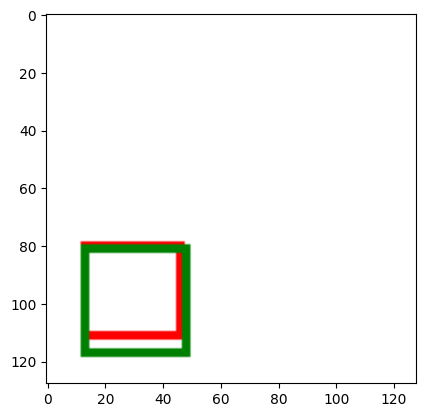

In [11]:
test_data, test_metadata = next(iter(test_rect_dataloader))
rect.eval()
instance = test_data[2].unsqueeze(0)
t_x, t_y, b_x, b_y = rect(instance)
plt.imshow(draw_rectangles(*test_metadata[2], t_x, t_y, b_x, b_y))

# Rectangle With SKI 

In [12]:
class EvalDataset(Dataset):
    def __init__(self, images, metadata):
        self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])
        
        # Unpack the metadata into separate variables
        metadata_tensor = torch.tensor(metadata).float()
        self.t_x, self.t_y, self.b_x, self.b_y = metadata_tensor[:, 0], metadata_tensor[:, 1], metadata_tensor[:, 2], metadata_tensor[:, 3]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        t_x, t_y, b_x, b_y = self.t_x[idx], self.t_y[idx], self.b_x[idx], self.b_y[idx]
        return image, t_x, t_y, b_x, b_y

batch_size = 64

rectangle_metadata = metadata[["rect_tl_x", "rect_tl_y", "rect_br_x", "rect_br_y"]]
train_images, test_images, train_rect_labels, test_rect_labels = train_test_split(images, rectangle_metadata.values, test_size=0.2, random_state=42)

# Create the training and test datasets for rectangles
train_rect_dataset = EvalDataset(train_images, train_rect_labels)
test_rect_dataset = EvalDataset(test_images, test_rect_labels)

train_rect_dataloader = DataLoader(train_rect_dataset, batch_size=batch_size, shuffle=True)
test_rect_dataloader = DataLoader(test_rect_dataset, batch_size=batch_size, shuffle=False)

/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_85203/1125484005.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])


In [13]:
def evaluate_model_rect(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, t_x, t_y, b_x, b_y in dataloader:
            inputs = inputs.to(device)
            t_x, t_y, b_x, b_y = t_x.to(device), t_y.to(device), b_x.to(device), b_y.to(device)
            tl_x, tl_y, br_x, br_y = model(inputs)
            preds = torch.stack((tl_x, tl_y, br_x, br_y), dim=1)
            labels = torch.stack((t_x, t_y, b_x, b_y), dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    mae = mean_absolute_error(all_labels, all_preds)
    print(f'Mean Absolute Error: {mae:.4f}')
    return mae

In [20]:
rect = RectangleDetector()

expression_1 = "all i. (Rect(i, t1, t2, b1, b2))"
expression_2 = "all t1 . ( (t1 = t11) and (b1 = b11) and (t2 = t22) and (b2 = b22) )"

learning_rules = [expression_1, expression_2]

loader = LoaderWrapper(loader=train_rect_dataloader, variables=["i"], targets=["t11", "t22", "b11", "b22"])

rule_to_data_loader_mapping = {
    expression_1: [loader],
    expression_2: [loader], 
}

predicates = {
    "Rect": rect
}

quantifier_impls = { "forall" : "pmean_error" }

connective_impls = {"eq": "sqrt"}

kb = KnowledgeBase(learning_rules = learning_rules, ancillary_rules=[], rule_to_data_loader_mapping=rule_to_data_loader_mapping, 
                   predicates=predicates, quantifier_impls=quantifier_impls,connective_impls=connective_impls)

In [21]:
evaluate_model_rect(rect, train_rect_dataloader, device='cpu')
print()
kb.optimize(num_epochs=40, lr=0.001, log_steps=10)
print()
evaluate_model_rect(rect, test_rect_dataloader, device='cpu')

Mean Absolute Error: 71.5635

['all i.Rect(i,t1,t2,b1,b2)', 'all t1.((t1 = t11) & (b1 = b11) & (t2 = t22) & (b2 = b22))']
Rule Outputs:  [tensor(1., grad_fn=<RsubBackward1>), tensor(0.3329, grad_fn=<RsubBackward1>)]
Epoch 1/40, Loss: 0.4717305898666382

['all i.Rect(i,t1,t2,b1,b2)', 'all t1.((t1 = t11) & (b1 = b11) & (t2 = t22) & (b2 = b22))']
Rule Outputs:  [tensor(1., grad_fn=<RsubBackward1>), tensor(0.9499, grad_fn=<RsubBackward1>)]
Epoch 11/40, Loss: 0.035406410694122314

['all i.Rect(i,t1,t2,b1,b2)', 'all t1.((t1 = t11) & (b1 = b11) & (t2 = t22) & (b2 = b22))']
Rule Outputs:  [tensor(1., grad_fn=<RsubBackward1>), tensor(0.9534, grad_fn=<RsubBackward1>)]
Epoch 21/40, Loss: 0.03297436237335205

['all i.Rect(i,t1,t2,b1,b2)', 'all t1.((t1 = t11) & (b1 = b11) & (t2 = t22) & (b2 = b22))']
Rule Outputs:  [tensor(1., grad_fn=<RsubBackward1>), tensor(0.9489, grad_fn=<RsubBackward1>)]
Epoch 31/40, Loss: 0.03616601228713989


Mean Absolute Error: 6.1966


np.float32(6.1966343)

In [22]:
kb.declarations

{'t1': tensor([ 75.7706,   9.5448,  11.0700,  71.8796,  68.6461,  43.1258,  19.3633,
          20.9336,  72.5230,  71.9279,  51.8438,  34.4011,  67.7525,  12.5404,
          50.7280,  55.3993,  54.7455,  60.4955,  68.6025,  17.6928,  41.7966,
          46.3870,  86.9227,  72.1262,  22.4565,  91.5176,  11.7051,  26.3196,
         103.6931,  52.4681,   5.8904,  18.2816,  75.0148,  25.7144,  93.4133,
          46.6719,  65.4299,  67.4676,  34.0145,   9.4244,  16.8264,  59.1082,
          65.4874,  93.6904,  36.9477,  76.4344,  96.4482,  72.1813,  51.9769,
          25.0959,  35.0489,  69.8699,  95.5157,  43.8486,  40.9589,  70.2227,
          24.9681,  89.2046,  30.8426,   8.7788,   2.2147,  71.4876,  65.9819,
          13.8527], grad_fn=<SelectBackward0>),
 't2': tensor([ 85.6715,  40.2389,  53.7527,  42.1337,  76.4738,   7.4010,  53.0808,
         107.9139,  82.5357,  79.6894,  12.8926,  67.8884,  74.1905,  46.3334,
          43.4316,  84.8274,  24.1507,  67.5409,  50.6763,  68.3927,  6

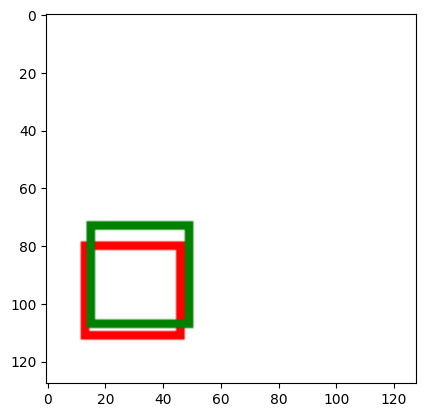

In [23]:
rect.eval()
instance = test_data[2].unsqueeze(0)
t_x, t_y, b_x, b_y = rect(instance)
plt.imshow(draw_rectangles(*test_metadata[2], t_x, t_y, b_x, b_y))

{'i': tensor([[[[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.]],

         [[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.]],

         [[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.

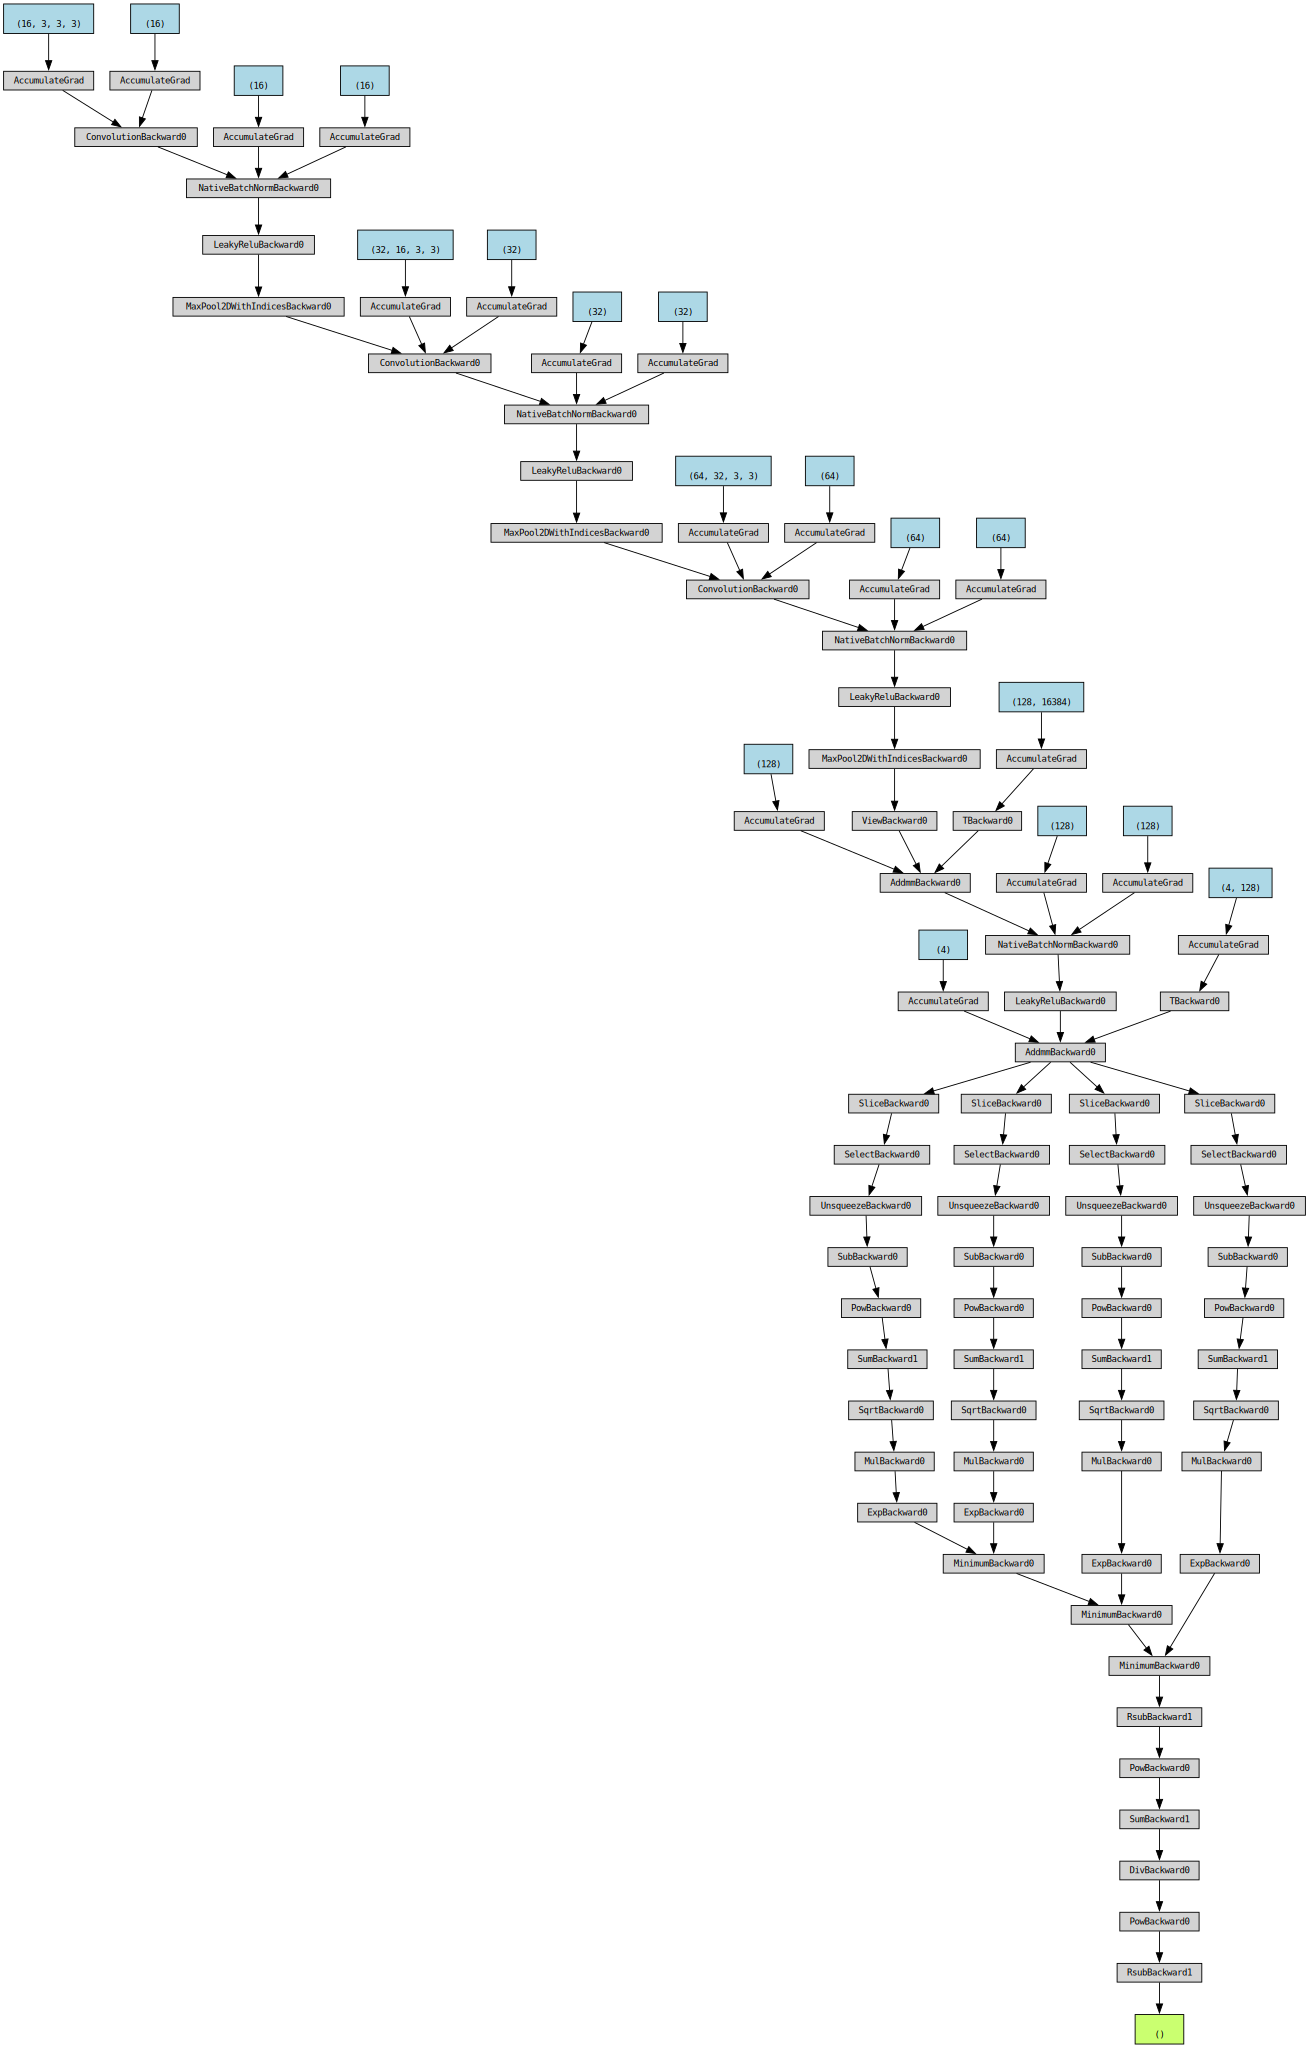

In [18]:
batch = next(iter(train_rect_dataloader))

var_mapping = {}

kb.partition_data(var_mapping,batch, loader)


kb.rules[1].comp_graph(var_mapping)

In [19]:
var_mapping["t11"].shape

torch.Size([64])